## Setting up the libraries and GPU

In [1]:
import torch
import numpy as np
import gym
import pybulletgym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn as nn
from torch.distributions import Categorical as Cat
from torch.optim import Adam as adam

C:\Users\pande\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpu = torch.device("cuda:0")
torch.cuda.empty_cache()

# Part 1

## Implementing Actor and Critic Model class

In [3]:
class model(torch.nn.Module):
    def __init__(self,states,actions):
        super(model,self).__init__()
        self.states = states
        self.actions = actions

        actor_layers = list()
        actor_layers.append(nn.Linear(self.states,64))
        actor_layers.append(nn.Tanh())
        actor_layers.append(nn.Linear(64, 64))
        actor_layers.append(nn.Tanh())
        actor_layers.append(nn.Linear(64,self.actions))
        actor_layers.append(nn.Softmax(dim=-1))

        critic_layers = list()
        critic_layers.append(nn.Linear(self.states, 64))
        critic_layers.append(nn.Tanh())
        critic_layers.append(nn.Linear(64, 64))
        critic_layers.append(nn.Tanh())
        critic_layers.append(nn.Linear(64, 1))

        self.actor_forward = nn.Sequential(*actor_layers)
        self.critic_forward = nn.Sequential(*critic_layers)
        
    def evaluation(self,states,move):
        dist = Cat(self.actor_forward(states))
        action_probability = dist.log_prob(move)
        entropy = dist.entropy()
        values = self.critic_forward(states)
        return action_probability,values,entropy

    def move(self,states): 
        distri = Cat(self.actor_forward(states))
        actions = distri.sample()
        probability_actions = distri.log_prob(actions)
        return actions.detach(),probability_actions.detach()

## Implementing PPO Algorithm

In [4]:
class PPO_algorithm:
    def __init__(self, dimension_state, dimension_actions, lr_actor, lr_critic, discount_factor, epochs, factor):
        self.list_of_rewards,self.actions,self.states,self.probability,self.completed = list(),list(),list(),list(),list()
        self.discount_factor,self.factor,self.epochs,self.losses = discount_factor,factor,epochs,nn.MSELoss()
        self.policy = model(dimension_state, dimension_actions).to(gpu)
        self.optimizer = torch.optim.Adam([{'params': self.policy.actor_forward.parameters(), 'lr': lr_actor},{'params': self.policy.critic_forward.parameters(), 'lr': lr_critic}])
        self.prev_policy = model(dimension_state, dimension_actions).to(gpu)
        self.prev_policy.load_state_dict(self.policy.state_dict())

    def ammend(self):
        disc_rew,rewards = 0,list()
        for reward, is_complete in zip(reversed(self.list_of_rewards), reversed(self.completed)):
            if is_complete:
                disc_rew = 0
            disc_rew = reward + (self.discount_factor * disc_rew)
            rewards.insert(0, disc_rew)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(gpu)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        end_actions,end_states,end_probability = torch.squeeze(torch.stack(self.actions, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.states, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.probability, dim=0)).detach().to(gpu)
        iteration = 0
        while iteration!=self.epochs:
            curr_probability, curr_state, entropy = self.policy.evaluation(end_states, end_actions)
            curr_state = torch.squeeze(curr_state)
            adv = rewards - curr_state.detach()   
            value1,value2 = torch.exp(curr_probability - end_probability.detach()) * adv,torch.clamp(torch.exp(curr_probability - end_probability.detach()), 1-self.factor, 1+self.factor) * adv
            loss = (0.5*self.losses(curr_state, rewards))-torch.min(value1, value2)-(0.01*entropy)
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            iteration+=1
        self.prev_policy.load_state_dict(self.policy.state_dict())
        self.actions,self.states,self.probability,self.list_of_rewards,self.completed = list(),list(),list(),list(),list()
        
    def movement_selection(self, provided_state):
        with torch.no_grad():
            movement, movement_probability = self.prev_policy.move(torch.FloatTensor(provided_state).to(gpu))
            self.states.append(torch.FloatTensor(provided_state).to(gpu))
            self.actions.append(movement)
            self.probability.append(movement_probability)
            return movement.item()

## Environment 1 (Acrobot-v1)

### Defining parameters for Acrobot-v1 environment

In [5]:
environment = gym.make("Acrobot-v1")
env_states,env_actions = environment.observation_space.shape[0],environment.action_space.n
length_episodes,number_of_episodes,discount_fact,number_epochs,eps = 700,150000,0.998,80,0.2                                
lr_critic,lr_actor = 0.001,0.0003
agent = PPO_algorithm(env_states, env_actions, lr_actor, lr_critic, discount_fact, number_epochs, eps)
list_of_episodic_reward,stepp = list(),0

C:\Users\pande\miniconda3\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\pande\miniconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


### Training Acrobot-v1 environment

In [6]:
while stepp <= number_of_episodes:
    state = environment.reset()
    episodic_reward = 0
    for t in range(1, length_episodes+1):
        action = agent.movement_selection(state)
        state, step_reward, comp,_ = environment.step(action)
        agent.list_of_rewards.append(step_reward)
        agent.completed.append(comp)
        episodic_reward += step_reward
        stepp +=1
        if stepp % (length_episodes * 4) == 0:
            agent.ammend()
        if comp:
            list_of_episodic_reward.append(episodic_reward)
            print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
            clear_output(wait=True)
            break
print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
environment.close()

Completed Training: [ ==================================================================================================== ] 100 %


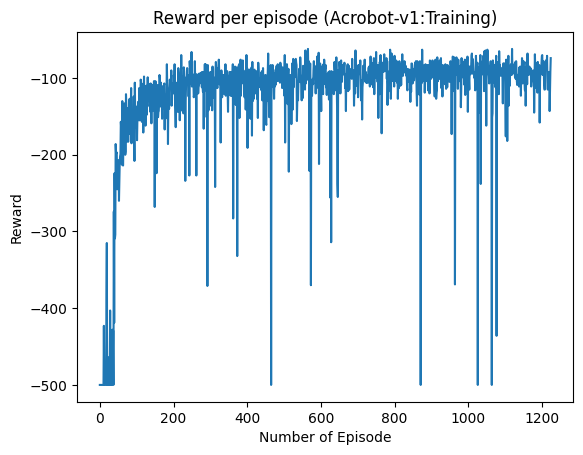

In [7]:
plt.plot(list_of_episodic_reward)
plt.title("Reward per episode (Acrobot-v1:Training)")
plt.xlabel("Number of Episode")
plt.ylabel("Reward")
plt.show()

In [8]:
print(len(list_of_episodic_reward))

1225


### Testing Acrobot-v1 Environment

In [21]:
list_of_test_rewards = list()
number_test_episodes = 10
for _ in range(number_test_episodes):
    episodic_reward = 0
    state = environment.reset()
    for _ in range(length_episodes):
        move = agent.movement_selection(state)
        state,rew,comp,_ = environment.step(move)
        episodic_reward += rew
        if comp == True:
            break
    list_of_test_rewards.append(episodic_reward)
    agent.list_of_rewards,agent.actions,agent.states,agent.probability,agent.completed = list(),list(),list(),list(),list()
environment.close()

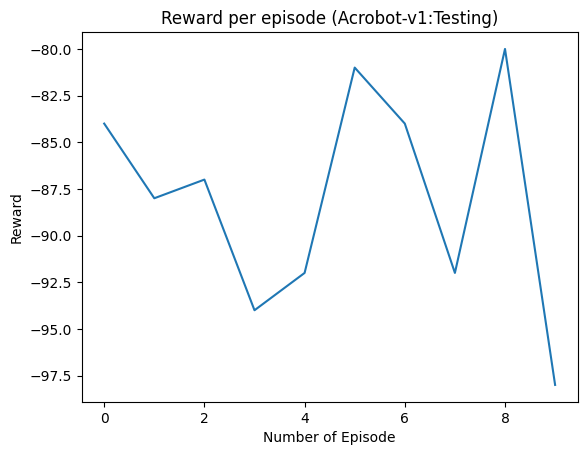

[-84.0, -88.0, -87.0, -94.0, -92.0, -81.0, -84.0, -92.0, -80.0, -98.0]


In [22]:
plt.plot(list_of_test_rewards)
plt.title("Reward per episode (Acrobot-v1:Testing)")
plt.xlabel("Number of Episode")
plt.ylabel("Reward")
plt.show()
print(list_of_test_rewards)

# Part 2

## Environment 2 (Lunar Lander)

### Model for Lunar Lander

In [3]:
class model(torch.nn.Module):
    def __init__(self,states,actions):
        super(model,self).__init__()
        self.states = states
        self.actions = actions

        # actor_layers = list()
        # actor_layers.append(nn.Linear(self.states,512))
        # actor_layers.append(nn.ReLU())
        # actor_layers.append(nn.Linear(512, 256))
        # actor_layers.append(nn.ReLU())
        # actor_layers.append(nn.Linear(256, 64))
        # actor_layers.append(nn.ReLU())
        # actor_layers.append(nn.Linear(64,self.actions))
        # actor_layers.append(nn.Softmax(dim=-1))
        
        actor_layers = list()
        actor_layers.append(nn.Linear(self.states,128))
        actor_layers.append(nn.Tanh())
        actor_layers.append(nn.Linear(128, 64))
        actor_layers.append(nn.Tanh())
        actor_layers.append(nn.Linear(64,self.actions))
        actor_layers.append(nn.Softmax(dim=-1))

        # critic_layers = list()
        # critic_layers.append(nn.Linear(self.states, 512))
        # critic_layers.append(nn.ReLU())
        # critic_layers.append(nn.Linear(512, 256))
        # critic_layers.append(nn.ReLU())
        # critic_layers.append(nn.Linear(256, 64))
        # critic_layers.append(nn.ReLU())
        # critic_layers.append(nn.Linear(64, 1))
        
        critic_layers = list()
        critic_layers.append(nn.Linear(self.states, 128))
        critic_layers.append(nn.Tanh())
        critic_layers.append(nn.Linear(128, 64))
        critic_layers.append(nn.Tanh())
        critic_layers.append(nn.Linear(64, 1))

        self.actor_forward = nn.Sequential(*actor_layers)
        self.critic_forward = nn.Sequential(*critic_layers)
        
    def evaluation(self,states,move):
        dist = Cat(self.actor_forward(states))
        action_probability = dist.log_prob(move)
        entropy = dist.entropy()
        values = self.critic_forward(states)
        return action_probability,values,entropy

    def move(self,states): 
        distri = Cat(self.actor_forward(states))
        actions = distri.sample()
        probability_actions = distri.log_prob(actions)
        return actions.detach(),probability_actions.detach()

### Implementing PPO Algorithm

In [4]:
class PPO_algorithm:
    def __init__(self, dimension_state, dimension_actions, lr_actor, lr_critic, discount_factor, epochs, factor):
        self.list_of_rewards,self.actions,self.states,self.probability,self.completed = list(),list(),list(),list(),list()
        self.discount_factor,self.factor,self.epochs,self.losses = discount_factor,factor,epochs,nn.MSELoss()
        self.policy = model(dimension_state, dimension_actions).to(gpu)
        self.optimizer = torch.optim.Adam([{'params': self.policy.actor_forward.parameters(), 'lr': lr_actor},{'params': self.policy.critic_forward.parameters(), 'lr': lr_critic}])
        self.prev_policy = model(dimension_state, dimension_actions).to(gpu)
        self.prev_policy.load_state_dict(self.policy.state_dict())

    def ammend(self):
        disc_rew,rewards = 0,list()
        for reward, is_complete in zip(reversed(self.list_of_rewards), reversed(self.completed)):
            if is_complete:
                disc_rew = 0
            disc_rew = reward + (self.discount_factor * disc_rew)
            rewards.insert(0, disc_rew)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(gpu)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        end_actions,end_states,end_probability = torch.squeeze(torch.stack(self.actions, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.states, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.probability, dim=0)).detach().to(gpu)
        iteration = 0
        while iteration!=self.epochs:
            curr_probability, curr_state, entropy = self.policy.evaluation(end_states, end_actions)
            curr_state = torch.squeeze(curr_state)
            adv = rewards - curr_state.detach()   
            value1,value2 = torch.exp(curr_probability - end_probability.detach()) * adv,torch.clamp(torch.exp(curr_probability - end_probability.detach()), 1-self.factor, 1+self.factor) * adv
            loss = (0.5*self.losses(curr_state, rewards))-torch.min(value1, value2)-(0.01*entropy)
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            iteration+=1
        self.prev_policy.load_state_dict(self.policy.state_dict())
        self.actions,self.states,self.probability,self.list_of_rewards,self.completed = list(),list(),list(),list(),list()
        
    def movement_selection(self, provided_state):
        with torch.no_grad():
            movement, movement_probability = self.prev_policy.move(torch.FloatTensor(provided_state).to(gpu))
            self.states.append(torch.FloatTensor(provided_state).to(gpu))
            self.actions.append(movement)
            self.probability.append(movement_probability)
            return movement.item()

### Defining parameters for environment 2

In [5]:
environment = gym.make("LunarLander-v2")
env_states,env_actions = environment.observation_space.shape[0],environment.action_space.n
# length_episodes,number_of_episodes,discount_fact,number_epochs,eps = 300,300000,0.98,10,0.2  #better
# lr_critic,lr_actor = 0.00015,0.00015  #better
length_episodes,number_of_episodes,discount_fact,number_epochs,eps = 1000,4*(1e5),0.99,80,0.2
lr_critic,lr_actor =0.001,0.0003
agent = PPO_algorithm(env_states, env_actions, lr_actor, lr_critic, discount_fact, number_epochs, eps)
list_of_episodic_reward,stepp = list(),0

C:\Users\pande\miniconda3\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\pande\miniconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


### Training Environment 2

In [6]:
while stepp <= number_of_episodes:
    state = environment.reset()
    episodic_reward = 0
    for t in range(1, length_episodes+1):
        action = agent.movement_selection(state)
        state, step_reward, comp,_ = environment.step(action)
        agent.list_of_rewards.append(step_reward)
        agent.completed.append(comp)
        episodic_reward += step_reward
        stepp +=1
        if stepp % (length_episodes * 4) == 0:
            agent.ammend()
        if comp:
            list_of_episodic_reward.append(episodic_reward)
            print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
            clear_output(wait=True)
            break
print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
environment.close()

Completed Training: [ ==================================================================================================== ] 100 %


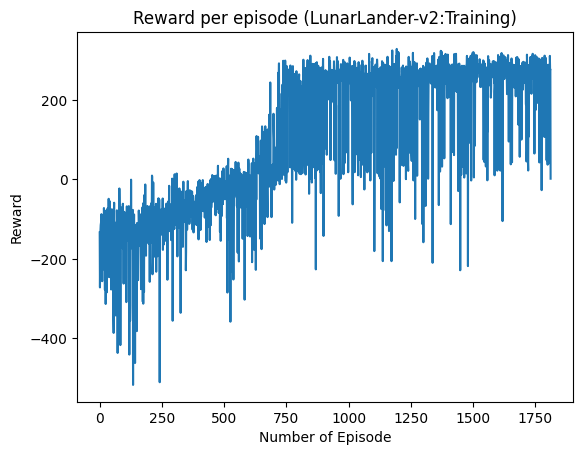

In [7]:
plt.plot(list_of_episodic_reward)
plt.title("Reward per episode (LunarLander-v2:Training)")
plt.xlabel("Number of Episode")
plt.ylabel("Reward")
plt.show()

In [8]:
print(len(list_of_episodic_reward))

1812


### Testing Environment

In [9]:
list_of_test_rewards = list()
number_test_episodes = 10
for _ in range(number_test_episodes):
    episodic_reward = 0
    state = environment.reset()
    for _ in range(length_episodes):
        move = agent.movement_selection(state)
        state,rew,comp,_ = environment.step(move)
        episodic_reward += rew
        if comp == True:
            break
    list_of_test_rewards.append(episodic_reward)
    agent.list_of_rewards,agent.actions,agent.states,agent.probability,agent.completed = list(),list(),list(),list(),list()
environment.close()

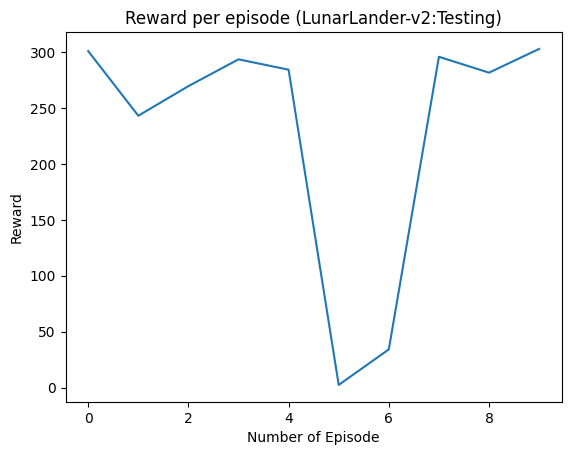

[300.87577512968426, 243.09597336172322, 269.56769689520775, 293.53102850170103, 284.27253245665673, 2.305764391374993, 34.08917676149824, 295.8187156933633, 281.6225286026954, 302.84706868129746]


In [10]:
plt.plot(list_of_test_rewards)
plt.title("Reward per episode (LunarLander-v2:Testing)")
plt.xlabel("Number of Episode")
plt.ylabel("Reward")
plt.show()
print(list_of_test_rewards)

In [11]:
np.mean(list_of_test_rewards)

230.80262604752025

## Environment 3 (InvertedDoublePendulumPyBulletEnv-v0)

### Model for environment 3

In [3]:
class model(torch.nn.Module):
    def __init__(self,states,actions):
        super(model,self).__init__()
        self.states = states
        self.actions = actions
        
        actor_layers = list()
        actor_layers.append(nn.Linear(self.states,256))
        actor_layers.append(nn.ReLU())
        actor_layers.append(nn.Linear(256,256))
        actor_layers.append(nn.ReLU())
        actor_layers.append(nn.Linear(256,self.actions))
        actor_layers.append(nn.Tanh())
        
        critic_layers = list()
        critic_layers.append(nn.Linear(self.states,256))
        critic_layers.append(nn.ReLU())
        critic_layers.append(nn.Linear(256, 256))
        critic_layers.append(nn.ReLU())
        critic_layers.append(nn.Linear(256,1))

        self.actor_forward = nn.Sequential(*actor_layers)
        self.critic_forward = nn.Sequential(*critic_layers)
        
    def evaluation(self,states,move):
        dist = self.actor_forward(states)
        act_va = torch.full((self.actions,),0.6*0.6).to(gpu).expand_as(dist)
        cov = torch.diag_embed(act_va).to(gpu)
        distri = torch.distributions.MultivariateNormal(dist,cov)
        if self.actions == 1:
            move = move.reshape(-1,self.actions)
        action_probability = distri.log_prob(move)
        entropy = distri.entropy()
        values = self.critic_forward(states)
        return action_probability,values,entropy

    def move(self,states): 
        distri = self.actor_forward(states)
        cov = torch.diag(torch.full((self.actions,),0.6*0.6).to(gpu)).unsqueeze(dim=0)
        dist = torch.distributions.MultivariateNormal(distri,cov)
        actions = dist.sample()
        probability_actions = dist.log_prob(actions)
        return actions.detach(),probability_actions.detach()

### Implementing PPO algorithm

In [4]:
class PPO_algorithm:
    def __init__(self, dimension_state, dimension_actions, lr_actor, lr_critic, discount_factor, epochs, factor):
        self.list_of_rewards,self.actions,self.states,self.probability,self.completed = list(),list(),list(),list(),list()
        self.discount_factor,self.factor,self.epochs,self.losses = discount_factor,factor,epochs,nn.MSELoss()
        self.policy = model(dimension_state, dimension_actions).to(gpu)
        self.optimizer = torch.optim.Adam([{'params': self.policy.actor_forward.parameters(), 'lr': lr_actor},{'params': self.policy.critic_forward.parameters(), 'lr': lr_critic}])
        self.prev_policy = model(dimension_state, dimension_actions).to(gpu)
        self.prev_policy.load_state_dict(self.policy.state_dict())

    def ammend(self):
        disc_rew,rewards = 0,list()
        for reward, is_complete in zip(reversed(self.list_of_rewards), reversed(self.completed)):
            if is_complete:
                disc_rew = 0
            disc_rew = reward + (self.discount_factor * disc_rew)
            rewards.insert(0, disc_rew)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(gpu)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        end_actions,end_states,end_probability = torch.squeeze(torch.stack(self.actions, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.states, dim=0)).detach().to(gpu),torch.squeeze(torch.stack(self.probability, dim=0)).detach().to(gpu)
        iteration = 0
        while iteration!=self.epochs:
            curr_probability, curr_state, entropy = self.policy.evaluation(end_states, end_actions)
            curr_state = torch.squeeze(curr_state)
            adv = rewards - curr_state.detach()   
            value1,value2 = torch.exp(curr_probability - end_probability.detach()) * adv,torch.clamp(torch.exp(curr_probability - end_probability.detach()), 1-self.factor, 1+self.factor) * adv
            loss = (0.5*self.losses(curr_state, rewards))-torch.min(value1, value2)-(0.01*entropy)
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            iteration+=1
        self.prev_policy.load_state_dict(self.policy.state_dict())
        self.actions,self.states,self.probability,self.list_of_rewards,self.completed = list(),list(),list(),list(),list()
        
    def movement_selection(self, provided_state):
        with torch.no_grad():
            movement, movement_probability = self.prev_policy.move(torch.FloatTensor(provided_state).to(gpu))
            self.states.append(torch.FloatTensor(provided_state).to(gpu))
            self.actions.append(movement)
            self.probability.append(movement_probability)
            return movement.detach().cpu().numpy().flatten()

### Defining parameters for environment 3

In [5]:
environment = gym.make("InvertedDoublePendulumPyBulletEnv-v0")
env_states,env_actions = environment.observation_space.shape[0],environment.action_space.shape[0]
length_episodes,number_of_episodes,discount_fact,number_epochs,eps = 1000,1000000,0.99,10,0.2
lr_critic,lr_actor = 0.0003,0.0003
agent = PPO_algorithm(env_states, env_actions, lr_actor, lr_critic, discount_fact, number_epochs, eps)
list_of_episodic_reward,stepp = list(),0

C:\Users\pande\miniconda3\lib\site-packages\gym\spaces\box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\pande\miniconda3\lib\site-packages\gym\core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
C:\Users\pande\miniconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing env

### Training environment 3

In [6]:
while stepp <= number_of_episodes:
    state = environment.reset()
    episodic_reward = 0
    for t in range(1, length_episodes+1):
        action = agent.movement_selection(state)
        state, step_reward, comp,_ = environment.step(action)
        agent.list_of_rewards.append(step_reward)
        agent.completed.append(comp)
        episodic_reward += step_reward
        stepp +=1
        if stepp % (length_episodes * 4) == 0:
            agent.ammend()
        if comp:
            list_of_episodic_reward.append(episodic_reward)
            print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")
            clear_output(wait=True)
            break
print("Completed Training:","[","="*int((stepp/number_of_episodes)*100),"]",int((stepp/number_of_episodes)*100),"%")


Completed Training: [ ==================================================================================================== ] 100 %


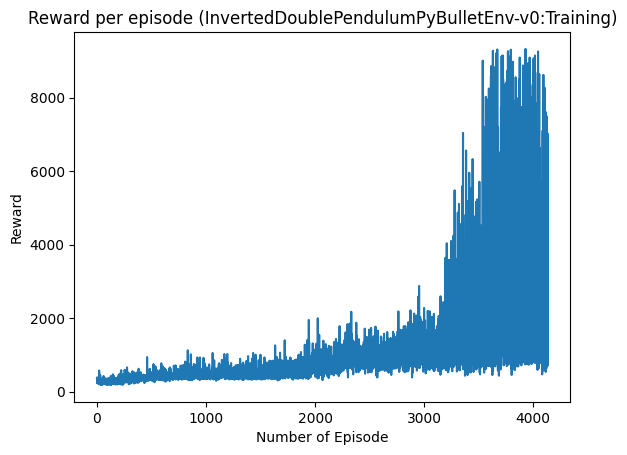

In [7]:
plt.plot(list_of_episodic_reward)
plt.title("Reward per episode (InvertedDoublePendulumPyBulletEnv-v0:Training)")
plt.xlabel("Number of Episode")
plt.ylabel("Reward")
plt.show()

In [8]:
print(len(list_of_episodic_reward))

4136


### Testing environment 3

In [21]:
list_of_test_rewards = list()
number_test_episodes = 10
environment = gym.make("InvertedDoublePendulumPyBulletEnv-v0")
for _ in range(number_test_episodes):
    episodic_reward = 0
    state = environment.reset()
    for _ in range(length_episodes):
        move = agent.movement_selection(state)
        state,rew,comp,_ = environment.step(move)
        episodic_reward += rew
        if comp == True:
            break
    list_of_test_rewards.append(episodic_reward)
    agent.list_of_rewards,agent.actions,agent.states,agent.probability,agent.completed = list(),list(),list(),list(),list()


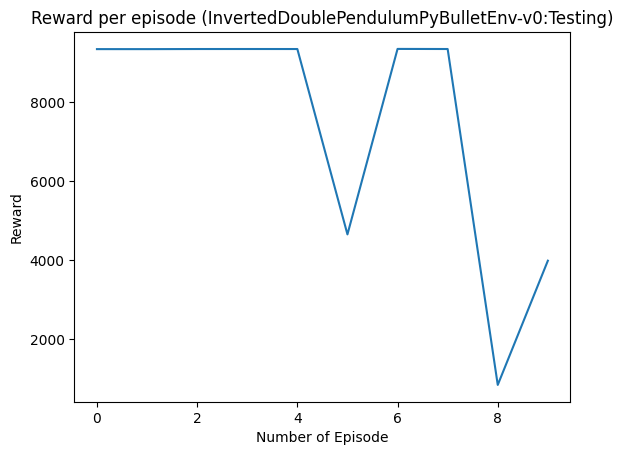

[9352.004779833183, 9351.658093874341, 9354.274446370853, 9354.680457771437, 9354.215246881355, 4655.027439322628, 9356.94179124612, 9354.639756027134, 838.5638604856778, 3987.9789303871316]


In [22]:
plt.plot(list_of_test_rewards)
plt.title("Reward per episode (InvertedDoublePendulumPyBulletEnv-v0:Testing)")
plt.xlabel("Number of Episode")
plt.ylabel("Reward")
plt.show()
print(list_of_test_rewards)

In [23]:
np.mean(list_of_test_rewards)

7495.998480219986